In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set()

# Import data

In [3]:
df = pd.read_csv('/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/data/income_per_day.csv')

In [4]:
df['Lag1'] = df['income'].shift(1)
df['Lag2'] = df['income'].shift(2)
df['RollingMean'] = df['income'].rolling(window=3).mean()
df.dropna(inplace=True)

# Convert Date to numeric features
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

In [5]:
df

,date,income,Lag1,Lag2,RollingMean,Year,Month,Day
2,2010-12-03,1.648220e+08,1.432860e+08,3.460146e+08,2.180409e+08,2010,12,3
3,2010-12-05,1.294085e+08,1.648220e+08,1.432860e+08,1.458388e+08,2010,12,5
4,2010-12-06,3.786618e+08,1.294085e+08,1.648220e+08,2.242974e+08,2010,12,6
5,2010-12-07,1.635399e+08,3.786618e+08,1.294085e+08,2.238701e+08,2010,12,7
6,2010-12-08,2.269111e+08,1.635399e+08,3.786618e+08,2.563709e+08,2010,12,8
...,...,...,...,...,...,...,...,...
300,2011-12-05,1.635399e+08,6.928137e+07,2.790082e+08,1.706098e+08,2011,12,5
301,2011-12-06,3.008440e+08,1.635399e+08,6.928137e+07,1.778884e+08,2011,12,6
302,2011-12-07,3.584565e+08,3.008440e+08,1.635399e+08,2.742801e+08,2011,12,7
303,2011-12-08,7.515071e+08,3.584565e+08,3.008440e+08,4.702692e+08,2011,12,8


In [6]:
# Split data into training and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]
train.set_index('date', inplace=True)#.drop(columns='date', inplace=True)
test.set_index('date', inplace=True)#.drop(columns='date', inplace=True)

X_train, y_train = train.drop(columns='income'), train['income']
X_test, y_test = test.drop(columns='income'), test['income']


In [7]:
# Function to create pipelines
def create_pipeline(model):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    return pipeline

# Function to train and evaluate models
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

# Dictionary to store results
results = {}

# List of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0),
    'LightGBM': LGBMRegressor()
}

# Train and evaluate each model
for name, model in models.items():
    results[name] = train_and_evaluate(model, X_train, y_train, X_test, y_test)

# Special Case: ARIMA (handled separately since it's not compatible with sklearn's pipeline)
def train_and_evaluate_arima(y_train, y_test, order=(5,1,0)):
    arima_model = ARIMA(y_train, order=order)
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=len(y_test))
    mse = mean_squared_error(y_test, arima_forecast)
    return mse

results['ARIMA'] = train_and_evaluate_arima(y_train, y_test)

# Compare results
for model, mse in results.items():
    print(f"{model}: MSE = {mse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 242, number of used features: 5
[LightGBM] [Info] Start training from score 112093503.656508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/aleksei/Desktop/projects/MLOPs-boootcamp-project/mlops-venv/lib/python3.10/site

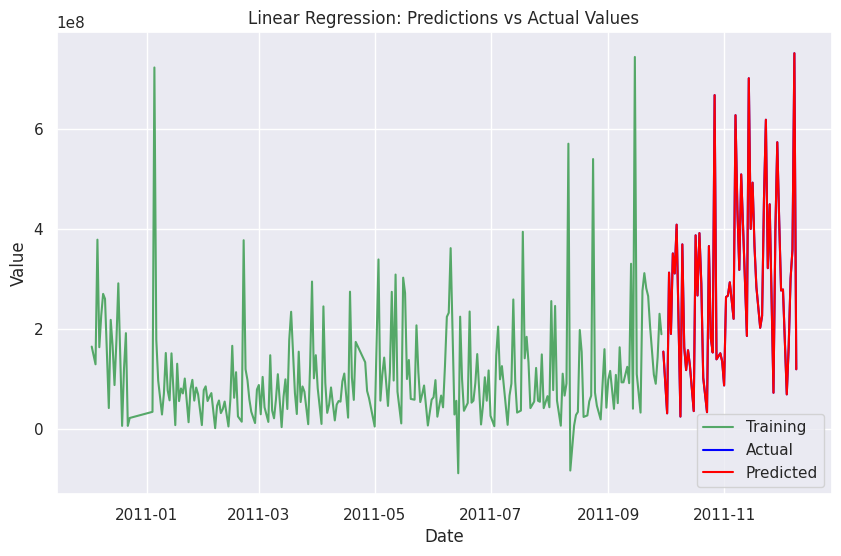

In [13]:
# Create and train the Linear Regression pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Plot the predictions vs the actual test data
plt.figure(figsize=(10, 6))
plt.plot(train.index, y_train, label='Training', color='g')
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Linear Regression: Predictions vs Actual Values')
plt.legend()
plt.show()

In [9]:
print(y_test.head(), y_pred)

date
2011-09-30    1.547475e+08
2011-10-02    3.136156e+07
2011-10-03    3.127316e+08
2011-10-04    1.902336e+08
2011-10-05    3.510959e+08
Name: income, dtype: float64 [1.54747480e+08 3.13615634e+07 3.12731574e+08 1.90233649e+08
 3.51095950e+08 3.11127231e+08 4.08650596e+08 2.48704605e+07
 3.69201973e+08 1.63696646e+08 1.17795472e+08 1.57489770e+08
 1.26627170e+08 3.57974716e+07 3.87333207e+08 2.67023942e+08
 3.91738277e+08 2.90546554e+08 1.02666452e+08 3.35955469e+07
 3.65853100e+08 1.81561333e+08 1.53013686e+08 6.67744684e+08
 1.39388570e+08 1.51416741e+08 1.34886540e+08 8.71099304e+07
 2.63888902e+08 2.66631397e+08 2.93356080e+08 2.20344610e+08
 6.27591952e+08 4.38571541e+08 3.18211676e+08 5.09146606e+08
 4.02505190e+08 1.86090074e+08 7.01451076e+08 4.00175905e+08
 4.92663100e+08 3.65699150e+08 2.84082748e+08 2.02499990e+08
 2.26139044e+08 4.61046501e+08 6.18533555e+08 3.21687496e+08
 4.49399510e+08 7.25210529e+07 3.97491735e+08 5.73535404e+08
 4.17277668e+08 2.77052607e+08 2.79008

Best Parameters: {'model__copy_X': True, 'model__fit_intercept': True, 'model__positive': False}
Mean Squared Error: 1.587618925213974e-14


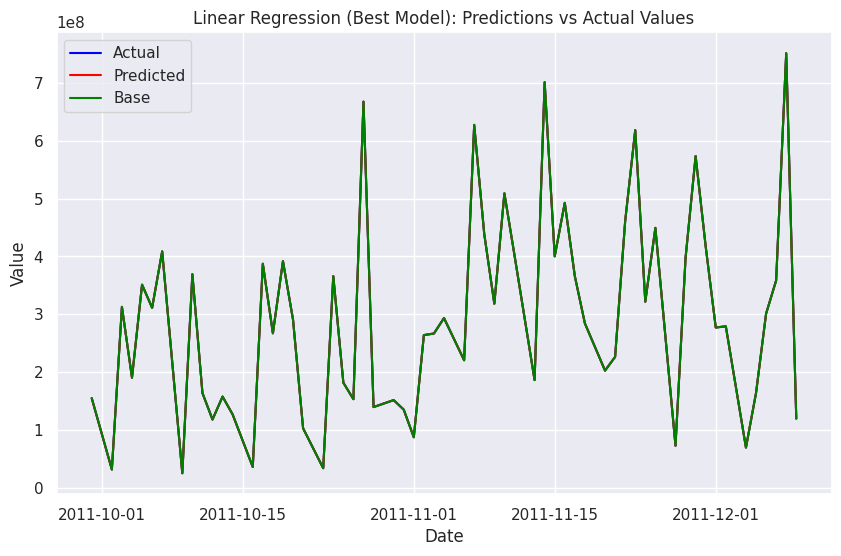

In [10]:
# Define the parameter grid
param_grid = {
    'model__fit_intercept': [True, False],
    'model__copy_X': [True, False],
    'model__positive': [True, False]
}

# Implement GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Predict on the test set using the best model
best_model = grid_search.best_estimator_
y_pred1 = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot the predictions vs the actual test data
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, y_pred1, label='Predicted', color='red')
plt.plot(test.index, y_pred, label='Base', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Linear Regression (Best Model): Predictions vs Actual Values')
plt.legend()
plt.show()


In [11]:
print((y_pred1.sum()-y_test.sum())/y_test.sum()*100)

2.126481378701513e-14
